# GCN


**1. Graph Representation**
- Represent graph as **adjacency matrix A** (n×n) where A[i,j] = 1 if nodes i and j are connected
- Node features matrix **X** (n×d) where n=number of nodes, d=feature dimension
- Labels matrix **Y** for supervised nodes

**2. Graph Normalization**
Key step: **Symmetric normalization** of adjacency matrix:
```
Ã = A + I_N  (add self-loops)
D̃ = diagonal degree matrix of Ã
Normalized adjacency: D̃^{-1/2} Ã D̃^{-1/2}
```
This prevents numerical instability and gradient issues.

**3. GCN Layer Operation**
Single layer forward propagation:
```
H^{(l+1)} = σ(D̃^{-1/2} Ã D̃^{-1/2} H^{(l)} W^{(l)})
```
Where:
- `H^{(l)}`: node representations at layer l (H⁰ = X)
- `W^{(l)}`: trainable weight matrix
- `σ`: activation function (ReLU commonly used)

**4. Multi-layer Architecture**
Typical 2-layer GCN architecture:
```
Z = softmax(Ã ReLU(Ã X W⁰) W¹)
```
Where:
- Layer 1: Transform features and aggregate first-hop neighbors
- Layer 2: Aggregate second-hop neighbors for prediction

**5. Training Pipeline**
1. **Data Preparation**:
   - Split nodes into train/val/test sets
   - Normalize adjacency matrix
   - Create masks for supervised learning

2. **Forward Pass**:
   - Layer 1: H¹ = ReLU(Ã X W⁰)
   - Apply dropout for regularization
   - Layer 2: Z = softmax(Ã H¹ W¹)

3. **Loss Computation**:
   - Use cross-entropy loss on labeled nodes:
   ```
   Loss = -Σ Y_train · log(Z_train)
   ```

4. **Backward Propagation**:
   - Compute gradients w.r.t. parameters W⁰, W¹
   - Update using Adam/SGD optimizer


## Advantages
- **Localized filters**: Each layer aggregates information from immediate neighbors
- **Efficient computation**: O(|E|) complexity with sparse matrices
- **Semi-supervised**: Learns from both labeled and unlabeled nodes
- **Inductive capability**: Can generalize to unseen graph structures


##  Implementation
```
# Pseudocode summary:
1. Load graph data (A, X, Y)
2. Add self-loops: A = A + I
3. Compute normalized adjacency: A_norm = D^{-1/2} A D^{-1/2}
4. Initialize parameters W1, W2
5. For each epoch:
   - H1 = relu(A_norm @ X @ W1)
   - H1 = dropout(H1)
   - Z = softmax(A_norm @ H1 @ W2)
   - loss = cross_entropy(Z[train], Y[train])
   - Update W1, W2 via gradient descent
```


https://tkipf.github.io/graph-convolutional-networks/


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
import networkx as nx
from scipy.sparse import coo_matrix

# set random seed
torch.manual_seed(42)
np.random.seed(42)

In [14]:
# ==================== 1. generate graph data ====================
class GraphData:
    def __init__(self, num_nodes=200, num_features=16, num_classes=3):
        self.num_nodes = num_nodes
        self.num_features = num_features
        self.num_classes = num_classes
        self.generate_data()
        
    def generate_data(self):
        # gen node feature
        self.features = torch.randn(self.num_nodes, self.num_features)
        
        # gen label
        self.labels = torch.randint(0, self.num_classes, (self.num_nodes,))
        
        # gen adjacency matrix
        adj_matrix = np.random.rand(self.num_nodes, self.num_nodes)
        adj_matrix = adj_matrix > 0.95  # sparsification
        np.fill_diagonal(adj_matrix, 1)  # add self-loop
        adj_matrix = adj_matrix.astype(np.float32)
        
        # transfer to COO mode
        rows, cols = np.where(adj_matrix)
        self.edge_index = torch.tensor([rows, cols], dtype=torch.long)
        
        # create mask：train/validate/test set
        idx = np.arange(self.num_nodes)
        np.random.shuffle(idx)
        
        self.train_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        self.val_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        self.test_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        
        self.train_mask[idx[:int(0.6*self.num_nodes)]] = True
        self.val_mask[idx[int(0.6*self.num_nodes):int(0.8*self.num_nodes)]] = True
        self.test_mask[idx[int(0.8*self.num_nodes):]] = True
        
        #calculate degree matrix and normalize adjacency matrix 
        self.normalize_adjacency()
    
    def normalize_adjacency(self):
        """symmetrically normalized adjacency matrix: D^{-1/2} A D^{-1/2}"""
        # calculate degree matrix
        row, col = self.edge_index
        deg = torch.zeros(self.num_nodes)
        deg = deg.scatter_add_(0, row, torch.ones_like(row, dtype=torch.float))
        
        # calculate D^{-1/2}
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        
        # normalizition
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        # normalizition with self-loop
        self.edge_weight = norm
        
        print(f"graph data generation is complete:")
        print(f"- node num: {self.num_nodes}")
        print(f"- feature dim: {self.num_features}")
        print(f"- class: {self.num_classes}")
        print(f"- edge num: {self.edge_index.shape[1]}")
        print(f"- train node: {self.train_mask.sum().item()}")
        print(f"- validate node: {self.val_mask.sum().item()}")
        print(f"- test node: {self.test_mask.sum().item()}")

# ==================== 2. GCN layer definition ====================
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)
    
    def forward(self, x, edge_index, edge_weight=None):
        """
        x: node num [num_nodes, in_features]
        edge_index: [2, num_edges]
        edge_weight:  [num_edges]
        """
        # feature transfer
        x = torch.matmul(x, self.weight)
        
        # graph conv
        row, col = edge_index
        
        if edge_weight is None:
            edge_weight = torch.ones(edge_index.shape[1], device=x.device)
        
        # aggregate neighbor information
        out = torch.zeros_like(x)
        for i in range(edge_index.shape[1]):
            out[row[i]] += x[col[i]] * edge_weight[i]
        
        # add bias
        if self.bias is not None:
            out += self.bias
        
        return out

# ==================== 3. GCN model definition ====================
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout=0.5):
        super(GCN, self).__init__()
        self.gc1 = GCNLayer(nfeat, nhid)
        self.gc2 = GCNLayer(nhid, nclass)
        self.dropout = dropout
        
    def forward(self, x, edge_index, edge_weight=None):
        # 1st GCN + ReLU + Dropout
        x = self.gc1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        
        # 2nd GCN (output)
        x = self.gc2(x, edge_index, edge_weight)
        
        return F.log_softmax(x, dim=1)
    
    def predict(self, x, edge_index, edge_weight=None):
        self.eval()
        with torch.no_grad():
            return self.forward(x, edge_index, edge_weight)

# ==================== 4. train and evaluation ====================
class Trainer:
    def __init__(self, model, data, lr=0.01, weight_decay=5e-4):
        self.model = model
        self.data = data
        self.optimizer = optim.Adam(model.parameters(), 
                                   lr=lr, 
                                   weight_decay=weight_decay)
        self.loss_fn = nn.NLLLoss()
        self.history = {'train_loss': [], 'val_loss': [], 
                       'train_acc': [], 'val_acc': []}
    
    def train_epoch(self):
        self.model.train()
        self.optimizer.zero_grad()
        
        # forward
        output = self.model(self.data.features, 
                           self.data.edge_index,
                           self.data.edge_weight)
        
        # loss（only train node）
        loss = self.loss_fn(output[self.data.train_mask], 
                           self.data.labels[self.data.train_mask])
        
        # backward
        loss.backward()
        self.optimizer.step()
        
        # accuracy
        pred = output.argmax(dim=1)
        train_acc = accuracy_score(
            self.data.labels[self.data.train_mask].numpy(),
            pred[self.data.train_mask].numpy()
        )
        
        return loss.item(), train_acc
    
    def evaluate(self, mask):
        self.model.eval()
        with torch.no_grad():
            output = self.model(self.data.features,
                               self.data.edge_index,
                               self.data.edge_weight)
            loss = self.loss_fn(output[mask], self.data.labels[mask])
            pred = output.argmax(dim=1)
            acc = accuracy_score(
                self.data.labels[mask].numpy(),
                pred[mask].numpy()
            )
        return loss.item(), acc
    
    def train(self, epochs=200, patience=50):
        print("\n begin training...")
        best_val_acc = 0
        patience_counter = 0
        
        for epoch in range(epochs):
            # train
            train_loss, train_acc = self.train_epoch()
            
            # validation
            val_loss, val_acc = self.evaluate(self.data.val_mask)
            
            # record
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            # print steps
            if (epoch + 1) % 20 == 0:
                print(f'Epoch {epoch+1:03d}: '
                      f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
                      f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
            
            # early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_gcn_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'early stopping at {epoch+1} epoch')
                    break
        
        # load Best model
        self.model.load_state_dict(torch.load('best_gcn_model.pth'))
        
    def plot_history(self):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # loss curve
        axes[0].plot(self.history['train_loss'], label='Train Loss')
        axes[0].plot(self.history['val_loss'], label='Val Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training and Validation Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # accuracy curve
        axes[1].plot(self.history['train_acc'], label='Train Acc')
        axes[1].plot(self.history['val_acc'], label='Val Acc')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Training and Validation Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# ==================== 5. main ====================
def main():
    # 1. gen data
    print("=" * 50)
    print("generating gragh data...")
    data = GraphData(num_nodes=200, num_features=16, num_classes=3)
    
    # 2. init model
    print("\n" + "=" * 50)
    print("init GCN model...")
    model = GCN(nfeat=data.num_features, 
                nhid=32,  # hidden layer
                nclass=data.num_classes,
                dropout=0.5)
    print(f"model param num: {sum(p.numel() for p in model.parameters()):,}")
    
    # 3. train
    print("\n" + "=" * 50)
    trainer = Trainer(model, data, lr=0.01, weight_decay=5e-4)
    trainer.train(epochs=200, patience=50)
    
    # 4. test
    print("\n" + "=" * 50)
    print("validate on test set...")
    test_loss, test_acc = trainer.evaluate(data.test_mask)
    print(f"result for test - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
    
    # 5. visualizition
    trainer.plot_history()
    
    # 6. show predict result
    print("\n" + "=" * 50)
    print("show predict result:")
    model.eval()
    with torch.no_grad():
        output = model.predict(data.features, data.edge_index, data.edge_weight)
        predictions = output.argmax(dim=1)
        
        # show first10 nodes' prediction results
        for i in range(min(10, data.num_nodes)):
            true_label = data.labels[i].item()
            pred_label = predictions[i].item()
            prob = torch.exp(output[i]).max().item()
            status = "✓" if true_label == pred_label else "✗"
            print(f"node {i:3d}: true label={true_label}, "
                  f"prediction={pred_label} {status}, "
                  f"confidence={prob:.3f}")



generating gragh data...
graph data generation is complete:
- node num: 200
- feature dim: 16
- class: 3
- edge num: 2066
- train node: 120
- validate node: 40
- test node: 40

init GCN model...
model param num: 643


 begin training...
Epoch 020: Train Loss: 1.0194, Train Acc: 0.4667 | Val Loss: 1.0629, Val Acc: 0.4250
Epoch 040: Train Loss: 0.9287, Train Acc: 0.5750 | Val Loss: 1.0413, Val Acc: 0.4750
Epoch 060: Train Loss: 0.8753, Train Acc: 0.6083 | Val Loss: 1.0366, Val Acc: 0.3750
Epoch 080: Train Loss: 0.8401, Train Acc: 0.6583 | Val Loss: 1.0505, Val Acc: 0.4250
early stopping at 92 epoch

validate on test set...
result for test - Loss: 1.2303, Accuracy: 0.2500


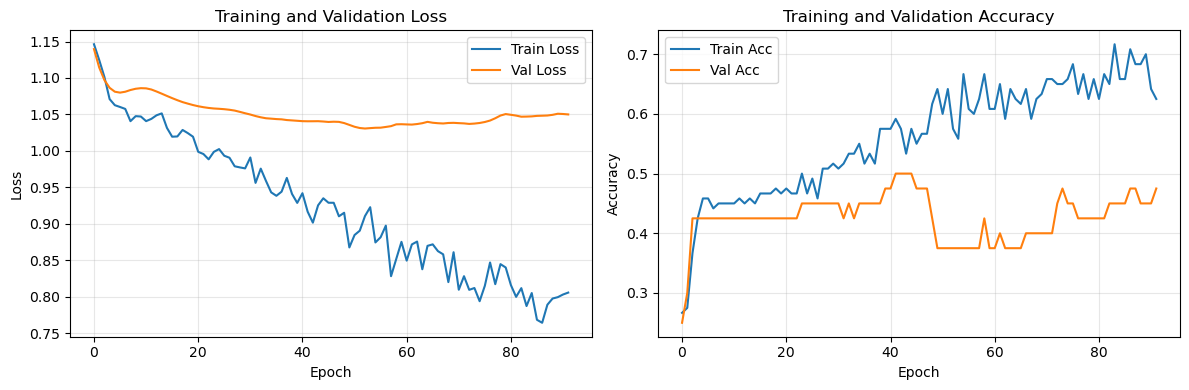


show predict result:
node   0: true label=2, prediction=2 ✓, confidence=0.577
node   1: true label=2, prediction=2 ✓, confidence=0.542
node   2: true label=0, prediction=2 ✗, confidence=0.476
node   3: true label=2, prediction=2 ✓, confidence=0.469
node   4: true label=0, prediction=2 ✗, confidence=0.593
node   5: true label=1, prediction=2 ✗, confidence=0.484
node   6: true label=2, prediction=2 ✓, confidence=0.485
node   7: true label=0, prediction=2 ✗, confidence=0.480
node   8: true label=0, prediction=2 ✗, confidence=0.426
node   9: true label=0, prediction=1 ✗, confidence=0.388


In [15]:
if __name__ == "__main__":
    main()

## Reference
1. https://zhuanlan.zhihu.com/p/633419078
2. https://tkipf.github.io/graph-convolutional-networks/
3. https://github.com/tkipf/gcn